# **Section 1:** Loading the dataset

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zipped_file_path = "/content/drive/MyDrive/NMCN Dataset"
extraction_folder = "nmcn_extracted_data"
extraction_path = os.path.join(zipped_file_path, extraction_folder)
os.makedirs(extraction_path, exist_ok=True)
experiment_zips = [
    "data01_direction4priors.zip",
    "data02_direction1prior.zip",
    "data03_orientation.zip"
]

for zip_file in experiment_zips:
    full_zip_path = os.path.join(zipped_file_path, zip_file)
    if os.path.exists(full_zip_path):
        print(f"   - Unzipping {zip_file}...")
        !unzip -o "{full_zip_path}" -d "{extraction_path}"
    else:
        print(f"   - Warning: {zip_file} not found at '{full_zip_path}'. Skipping.")

print("All experiment files extracted.")
!ls -l "{extraction_path}"

   - Unzipping data01_direction4priors.zip...
Archive:  /content/drive/MyDrive/NMCN Dataset/data01_direction4priors.zip
   creating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/
  inflating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.DS_Store  
   creating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.svn/
  inflating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.svn/all-wcprops  
  inflating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.svn/entries  
   creating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.svn/prop-base/
   creating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.svn/props/
   creating: /content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data/data01_direction4priors/.svn/text-base/
   creating: /content/drive/MyDrive/NMC

Running Mr. Abdehaghighi's script

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.io
import re

def load_all_experiments(base_path, experiment_configs):
    """
    Loads all raw .mat files from multiple experiment folders, correctly extracts
    trial-by-trial data and returns a dictionary of pandas DataFrames.
    """
    all_experiments_data = {}

    for exp_folder, config in experiment_configs.items():
        print(f"--- Processing Experiment: {exp_folder} ---")

        exp_path = os.path.join(base_path, exp_folder)
        if not os.path.isdir(exp_path):
            print(f"  - Directory not found. Skipping.")
            continue

        all_trials_list = []
        for dirpath, _, filenames in os.walk(exp_path):
            for filename in filenames:
                if filename.endswith('.mat') and 'sub' in filename:
                    file_path = os.path.join(dirpath, filename)
                    try:
                        mat = scipy.io.loadmat(file_path, simplify_cells=True)

                        if 'task' in mat and isinstance(mat['task'], list) and len(mat['task']) > 1:
                            task_data = mat['task'][1]
                            rand_vars = task_data.get('randVars', {})

                            n_trials_key = config.get('n_trials_key', 'prodcoor')
                            n_trials = len(rand_vars.get(n_trials_key, []))
                            if n_trials == 0: continue

                            subject_id_match = re.search(r'sub(\d+)', filename)
                            subject_id = int(subject_id_match.group(1)) if subject_id_match else -1

                            trial_vars = {}
                            for key, path in config['vars'].items():
                                if 'randVars' in path:
                                    trial_vars[key] = rand_vars.get(path.split('.')[1])
                                else:
                                    trial_vars[key] = task_data.get(path)

                            for i in range(n_trials):
                                trial_dict = {'subject_id': subject_id, 'trial_index': i + 1}
                                for key, data_array in trial_vars.items():
                                    if data_array is not None and i < len(data_array):
                                        trial_dict[key] = data_array[i]

                                all_trials_list.append(trial_dict)

                    except Exception as e:
                        print(f"   - Warning: Could not fully process '{filename}'. Error: {e}")

        if all_trials_list:
            df = pd.DataFrame(all_trials_list)

            if 'estimate_coords' in df.columns:
                coords = df['estimate_coords'].apply(
                    lambda x: pd.Series(x, index=['estimate_x', 'estimate_y']) if isinstance(x, (list, np.ndarray)) and len(x) >= 2 else pd.Series([np.nan, np.nan], index=['estimate_x', 'estimate_y'])
                )
                df = pd.concat([df.drop('estimate_coords', axis=1), coords], axis=1)

            all_experiments_data[exp_folder] = df
            print(f"  - ✅ Success! Assembled {len(df)} total trial entries.")
        else:
            print(f"  - ❌ No data found in this directory.")

    return all_experiments_data

# 1. Define the base path and experiment configurations
BASE_DATA_PATH = '/content/drive/MyDrive/NMCN Dataset/nmcn_extracted_data'

EXPERIMENT_CONFIGS = {
    'data01_direction4priors': {
        'n_trials_key': 'prodcoor',
        'vars': {
            'motion_direction': 'randVars.myRandomDir',
            'motion_coherence': 'randVars.myRandomCoh',
            'reaction_time': 'reactionTime',
            'estimate_coords': 'randVars.prodcoor'
        }
    },
    'data02_direction1prior': {
        'n_trials_key': 'prodcoor',
        'vars': {
            'motion_direction': 'randVars.myRandomDir',
            'motion_coherence': 'randVars.myRandomCoh',
            'reaction_time': 'reactionTime',
            'estimate_coords': 'randVars.prodcoor'
        }
    },
    'data03_orientation': {
        'n_trials_key': 'prodcoor',
        'vars': {
            'stimulus_orientation': 'randVars.myRandomloc',
            'stimulus_contrast': 'randVars.myRandomCon',
            'reaction_time': 'reactionTime',
            'estimate_coords': 'randVars.prodcoor'
        }
    }
}

# 2. Load all datasets
dataframes = load_all_experiments(BASE_DATA_PATH, EXPERIMENT_CONFIGS)

# 3. Display the head of each created DataFrame
print("\n" + "="*50)
print("              DATA LOADING COMPLETE")
print("="*50)

if dataframes:
    for exp_name, df in dataframes.items():
        print(f"\n--- DataFrame Head for: '{exp_name}' ---")
        print(f"Total entries loaded: {len(df)}")
        print(df.head())
else:
    print("\nNo dataframes were created.")

--- Processing Experiment: data01_direction4priors ---
  - ✅ Success! Assembled 97250 total trial entries.
--- Processing Experiment: data02_direction1prior ---
  - ✅ Success! Assembled 60500 total trial entries.
--- Processing Experiment: data03_orientation ---
  - ✅ Success! Assembled 70500 total trial entries.

              DATA LOADING COMPLETE

--- DataFrame Head for: 'data01_direction4priors' ---
Total entries loaded: 97250
   subject_id  trial_index  motion_direction  motion_coherence  estimate_x  \
0           1            1             225.0              0.12   -1.749685   
1           1            2             225.0              0.12   -1.819693   
2           1            3             235.0              0.06   -1.562674   
3           1            4             225.0              0.06   -1.601388   
4           1            5             215.0              0.24   -1.639461   

   estimate_y  
0   -1.785666  
1   -1.714269  
2   -1.951422  
3   -1.919781  
4   -1.887371  


### Loading all the needed libraries

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score

### Calculating Errors


--- Calculating Errors and Generating Plots ---


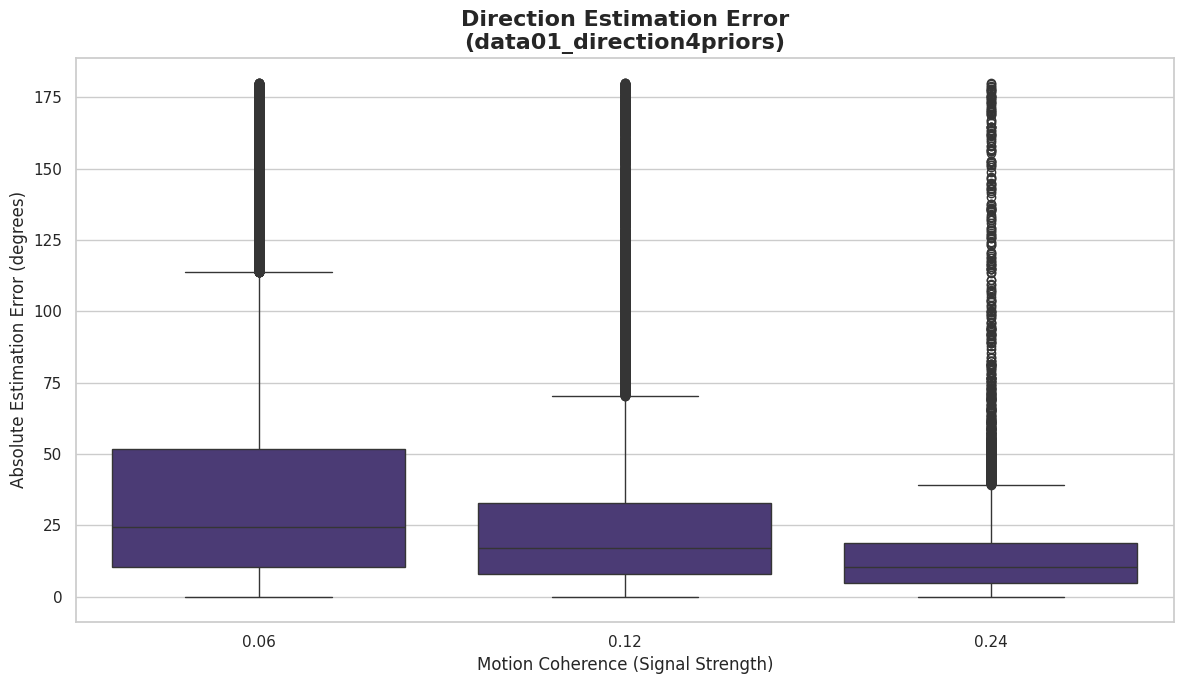

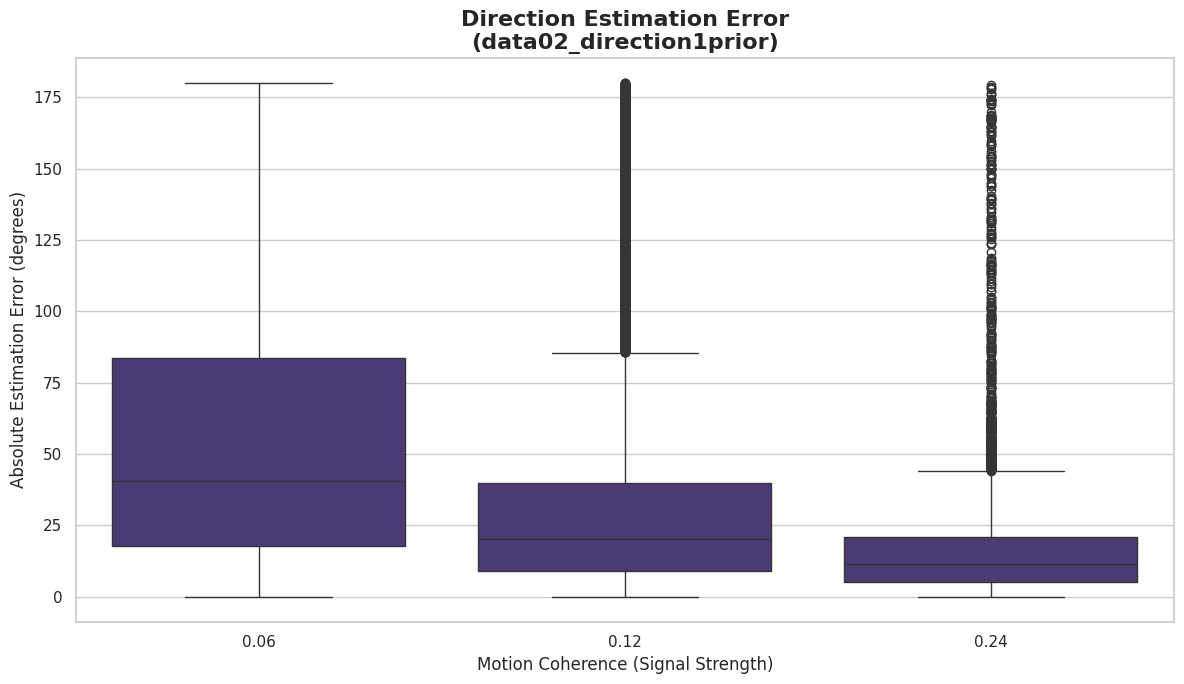

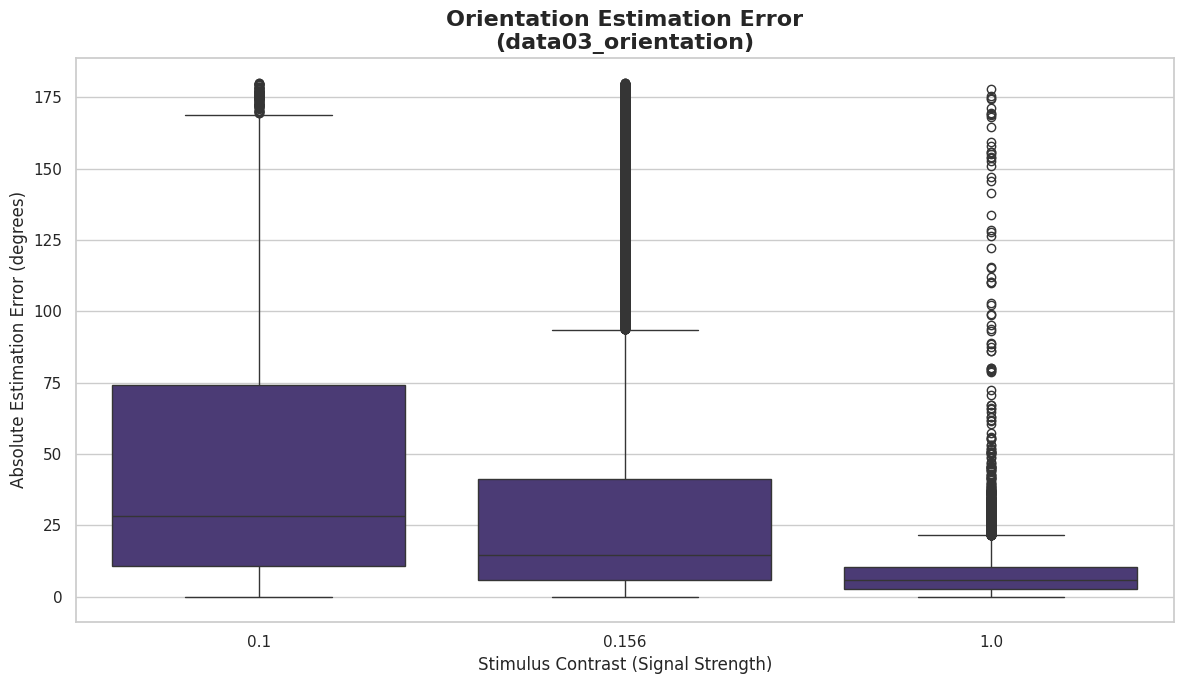

In [ ]:
sns.set_theme(style="whitegrid", palette="viridis")
print("\n--- Calculating Errors and Generating Plots ---")

if 'dataframes' in locals() and dataframes:
    for exp_name, df in dataframes.items():

        if 'direction' in exp_name:
            true_angle_col = 'motion_direction'
            strength_col = 'motion_coherence'
            x_label = 'Motion Coherence (Signal Strength)'
            plot_title = 'Direction Estimation Error'
        elif 'orientation' in exp_name:
            true_angle_col = 'stimulus_orientation'
            strength_col = 'stimulus_contrast'
            x_label = 'Stimulus Contrast (Signal Strength)'
            plot_title = 'Orientation Estimation Error'
        else:
            print(f"\n  - Could not determine type for '{exp_name}'. Skipping.")
            continue


        df['estimated_angle'] = np.degrees(np.arctan2(df['estimate_y'], df['estimate_x']))
        error = df['estimated_angle'] - df[true_angle_col]

        df['estimation_error'] = (error + 180) % 360 - 180

        plt.figure(figsize=(12, 7))
        ax = sns.boxplot(data=df, x=strength_col, y=abs(df['estimation_error']))

        plt.title(f'{plot_title}\n({exp_name})', fontsize=16, fontweight='bold')
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel('Absolute Estimation Error (degrees)', fontsize=12)

        if df[strength_col].nunique() > 10:
             plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

else:
    print("\n Error: The 'dataframes' dictionary was not found.")
    print("Please make sure you have successfully run the initial data loading script first.")

All three plots consistently demonstrate that as the signal strength increases, the absolute estimation error decreases.

**Inverse Relationship:** In all three experiments, a stronger sensory signal leads to a more accurate response.

   1. For the direction tasks, as motion coherence increases from 0.06 to 0.24, the median absolute error and the overall spread of errors decrease significantly.

   2. For the orientation task, as stimulus contrast increases from 0.1 to 1.0, the same pattern holds, with errors becoming much smaller at the highest contrast level.

**Decreased Variability:** Not only does the median error decrease with higher signal strength, but the variability of the error also shrinks. This is visible by the smaller size of the boxes (the interquartile range) at higher coherence and contrast levels.

**Outliers:** The plots also show a number of outliers, particularly at the highest signal strengths. These represent trials where the participant's response was unusually far from the true value, even when the signal was clear.

These visualizations provide strong support for a Bayesian model of perception. In a Bayesian framework, the brain combines sensory evidence (the likelihood) with prior beliefs (the prior) to form a final estimate (the posterior).

**Likelihood Precision:** The signal strength (coherence or contrast) directly relates to the precision, or narrowness, of the likelihood function. A strong signal (high coherence/contrast) results in a narrow likelihood, indicating high certainty in the sensory evidence. A weak signal results in a wide likelihood, indicating uncertainty.

**Model Validation:** Figures show that when the likelihood is narrow (high signal strength), the estimation error is low. This is exactly what a Bayesian model would predict, as the final estimate is heavily weighted by the reliable sensory evidence. When the likelihood is wide (low signal strength), the brain relies more on its prior beliefs, or is simply more uncertain, leading to higher estimation error and variability.

`get_final_array(data_container)`:
Unpacks a data object from a .mat file until it's no longer a single-element array, returning the final data.

`load_all_experiments(base_path)`:
Loads all raw .mat files from the three experiment folders, extracts trial-by-trial data, and returns a single combined pandas DataFrame.

#**Section 2 (Q.2):** Calculate the circular distances between past trial estimates and current trial displayed directions. Split the data into a train and test set. Train a linear regression to predict the error from that feature on the train set and calculate the fit's R-squared on the test set. How good is the fit? Can you find more predictive features?**


In [ ]:
train_sets = {}
test_sets = {}

print("--- Starting Feature Engineering and Train-Test Split ---")

if 'dataframes' in locals() and dataframes:
    for exp_name, df in dataframes.items():
        print(f"\nProcessing: '{exp_name}'")

        if 'estimated_angle' not in df.columns:
             df['estimated_angle'] = np.degrees(np.arctan2(df['estimate_y'], df['estimate_x']))

        df['prev_estimated_angle'] = df.groupby('subject_id')['estimated_angle'].shift(1)

        true_angle_col = 'motion_direction' if 'direction' in exp_name else 'stimulus_orientation'

        dist = df[true_angle_col] - df['prev_estimated_angle']
        df['dist_to_prev_estimate'] = (dist + 180) % 360 - 180

        df_processed = df.dropna(subset=['prev_estimated_angle', 'dist_to_prev_estimate']).copy()
        print(f"  - Calculated 'dist_to_prev_estimate' feature.")

        subject_ids = df_processed['subject_id'].unique()

        train_subject_ids, test_subject_ids = train_test_split(
            subject_ids,
            test_size=0.2,
            random_state=42
        )

        train_df = df_processed[df_processed['subject_id'].isin(train_subject_ids)]
        test_df = df_processed[df_processed['subject_id'].isin(test_subject_ids)]

        train_sets[exp_name] = train_df
        test_sets[exp_name] = test_df
        print(f"  - Split data into 80% train and 20% test sets by subject.")

    print("\n" + "="*50)
    print("           DATA SPLIT VERIFICATION")
    print("="*50)
    for exp_name in train_sets.keys():
        train_df = train_sets[exp_name]
        test_df = test_sets[exp_name]
        print(f"\nExperiment: '{exp_name}'")
        print(f"  - Train Set: {len(train_df)} trials from {train_df['subject_id'].nunique()} subjects.")
        print(f"  - Test Set:  {len(test_df)} trials from {test_df['subject_id'].nunique()} subjects.")
        print("\n--- Train Set Columns ---")
        print(train_df.info())


else:
    print("\n Error: The 'dataframes' dictionary was not found.")
    print("Please make sure you have successfully run the data loading script first.")

--- Starting Feature Engineering and Train-Test Split ---

Processing: 'data01_direction4priors'
  - Calculated 'dist_to_prev_estimate' feature.
  - Split data into 80% train and 20% test sets by subject.

Processing: 'data02_direction1prior'
  - Calculated 'dist_to_prev_estimate' feature.
  - Split data into 80% train and 20% test sets by subject.

Processing: 'data03_orientation'
  - Calculated 'dist_to_prev_estimate' feature.
  - Split data into 80% train and 20% test sets by subject.

           DATA SPLIT VERIFICATION

Experiment: 'data01_direction4priors'
  - Train Set: 61842 trials from 9 subjects.
  - Test Set:  20982 trials from 3 subjects.

--- Train Set Columns ---
<class 'pandas.core.frame.DataFrame'>
Index: 61842 entries, 10001 to 97201
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             61842 non-null  int64  
 1   trial_index            61842 non-null  int64  

### Linear Regression

In [ ]:
if 'train_sets' in locals() and train_sets:
    for exp_name, train_df in train_sets.items():
        print(f"\n--- Fitting Model for: '{exp_name}' ---")

        if 'direction' in exp_name:
            strength_col = 'motion_coherence'
            true_angle_col = 'motion_direction'
        else:
            strength_col = 'stimulus_contrast'
            true_angle_col = 'stimulus_orientation'

        model_df = train_df.copy()
        model_df['sin_angle'] = np.sin(np.deg2rad(model_df[true_angle_col]))
        model_df['cos_angle'] = np.cos(np.deg2rad(model_df[true_angle_col]))

        predictor_cols = [strength_col, 'dist_to_prev_estimate', 'sin_angle', 'cos_angle']
        target_col = 'estimation_error'
        all_model_cols = [target_col] + predictor_cols

        cleaned_df = model_df[all_model_cols].dropna()

        if cleaned_df.empty:
            print("  - Warning: No valid data remains after cleaning. Skipping model.")
            continue

        y_train = cleaned_df[target_col]
        X_train = cleaned_df[predictor_cols]
        X_train = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        print(results.summary())

else:
    print("\n Error: The 'train_sets' dictionary was not found.")
    print("Please make sure you have successfully run the feature engineering script first.")



--- Fitting Model for: 'data01_direction4priors' ---
                            OLS Regression Results                            
Dep. Variable:       estimation_error   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     647.1
Date:                Sat, 12 Jul 2025   Prob (F-statistic):               0.00
Time:                        03:05:18   Log-Likelihood:            -3.2566e+05
No. Observations:               61840   AIC:                         6.513e+05
Df Residuals:                   61835   BIC:                         6.514e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

**Previous Trial's Estimate is a Strong Predictor (Serial Dependence)**: In **all three experiments**, the `dist_to_prev_estimate` has a statistically significant (`P>|t|` is 0.000) and negative coefficient. This is a classic finding called **attractive serial dependence**. It means that participants' current estimate is biased *towards* their estimate from the previous trial. The negative coefficient shows that as the distance between the current stimulus and the previous response increases, the error tends to become more negative (it's pulled back towards that previous response).

**Signal Strength (Coherence/Contrast) Has a Complex Role**:
1. In `data01` (4 priors), `motion_coherence` has a significant negative coefficient, confirming that higher coherence reduces error.
2. In `data02` (1 prior), `motion_coherence` is **not a significant predictor**. This is a fascinating difference! It suggests that when the prior is very strong and simple (always one direction), the effect of sensory evidence on the average error is much weaker.
3. In `data03` (orientation), `stimulus_contrast` has a significant *positive* coefficient. While counter-intuitive at first glance, this does not mean higher contrast *increases* error. Because the model predicts raw error (not absolute error), this likely reflects a systematic bias, where higher contrast pushes estimates in a specific direction (e.g., consistently clockwise) for certain orientations.

**Stimulus Direction Matters (Systematic Bias)**:
In the experiments with varied priors (`data01` and `data03`), the `sin_angle` and `cos_angle` terms are highly significant. This means the error is not random but depends on the stimulus itself. For example, participants might be systematically more biased when estimating diagonal directions compared to horizontal or vertical ones. This is a well-known phenomenon sometimes called the "oblique effect."

**Low R-squared Low**
`R-squared` values are low (e.g., 0.04, or 4%). It means that a simple linear model, while identifying significant factors, cannot explain most of the variability in human estimation error.
1.  **Perception is Noisy:** Human responses are inherently stochastic, or random. A linear model predicts a single value and can't capture this fundamental noise.
2.  **Linear Models are a Mismatch:** The model assumes a linear relationship and a normally-distributed error, but your estimation error is **circular** (from -180 to 180).

Because of these limitations, we need a more sophisticated Bayesian model.



### Logistic Regression

In [ ]:
LAPSE_THRESHOLD = 90.0

if 'train_sets' in locals() and train_sets:
    for exp_name, train_df in train_sets.items():
        print(f"\n--- Fitting Model for: '{exp_name}' ---")

        train_df['is_lapse'] = (np.abs(train_df['estimation_error']) > LAPSE_THRESHOLD).astype(int)

        if 'direction' in exp_name:
            strength_col = 'motion_coherence'
            true_angle_col = 'motion_direction'
        else:
            strength_col = 'stimulus_contrast'
            true_angle_col = 'stimulus_orientation'

        model_df = train_df.copy()
        model_df['sin_angle'] = np.sin(np.deg2rad(model_df[true_angle_col]))
        model_df['cos_angle'] = np.cos(np.deg2rad(model_df[true_angle_col]))

        predictor_cols = [strength_col, 'dist_to_prev_estimate', 'sin_angle', 'cos_angle']
        target_col = 'is_lapse'
        all_model_cols = [target_col] + predictor_cols
        cleaned_df = model_df[all_model_cols].dropna()

        if cleaned_df.empty or cleaned_df[target_col].nunique() < 2:
            print(f"  - Warning: Not enough data or only one class ({cleaned_df[target_col].unique()}) present after cleaning. Skipping model.")
            continue

        y_train = cleaned_df[target_col]
        X_train = cleaned_df[predictor_cols]
        X_train = sm.add_constant(X_train)
        logit_model = sm.Logit(y_train, X_train)
        result = logit_model.fit()
        print(result.summary())

else:
    print("\n Error: The 'train_sets' dictionary was not found.")
    print("Please make sure you have successfully run the previous scripts first.")



--- Fitting Model for: 'data01_direction4priors' ---
Optimization terminated successfully.
         Current function value: 0.250137
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               is_lapse   No. Observations:                61842
Model:                          Logit   Df Residuals:                    61837
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Jul 2025   Pseudo R-squ.:                  0.1102
Time:                        03:14:07   Log-Likelihood:                -15469.
converged:                       True   LL-Null:                       -17385.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4224

/tmp/ipython-input-24-1250410648.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['is_lapse'] = (np.abs(train_df['estimation_error']) > LAPSE_THRESHOLD).astype(int)


                           Logit Regression Results                           
Dep. Variable:               is_lapse   No. Observations:                49475
Model:                          Logit   Df Residuals:                    49470
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Jul 2025   Pseudo R-squ.:                  0.2206
Time:                        03:14:08   Log-Likelihood:                -10382.
converged:                       True   LL-Null:                       -13321.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3569      0.053     -6.682      0.000      -0.462      -0.252
stimulus_contrast        -6.5883      0.324    -20.313      0.000      -7.224      -5.953
dist_to_

A "lapse" trial is a trial where the participant was likely guessing, resulting in a large error.

**Signal Strength is the Most Decisive Factor**:
In **all three experiments**, the coefficient for `motion_coherence` or `stimulus_contrast` is **large, negative, and highly significant** (`P>|z|` is 0.000). This is a strong and clear result. As the sensory evidence becomes clearer (higher coherence or contrast), the probability of the participant guessing or making a large error **dramatically decreases**. This is the most powerful predictor of lapse trials in your data.

**Previous Trial History Does Not Predict Lapses**:
In all three models, the `dist_to_prev_estimate` coefficient is very close to zero and is **not statistically significant** in the two largest experiments. While the previous trial's estimate *pulls* the current estimate (affecting its bias), it does **not** seem to affect the probability of a catastrophic lapse. This suggests that serial dependence is a mechanism for fine-tuning responses, not for preventing guessing.

**Stimulus Direction Influences Lapses (Systematic Biases)**:
In the `data01` (4 priors) and `data03` (orientation) experiments, the `sin_angle` and `cos_angle` terms are highly significant. This confirms that the likelihood of lapsing depends on the stimulus being presented. Participants are more likely to make large errors for certain directions/orientations than for others (e.g., oblique angles are often harder to judge than cardinal angles). This effect is much weaker in the simpler `data02` experiment, which had only one prior.



--- Generating Correlation Matrix for 'data01_direction4priors' ---


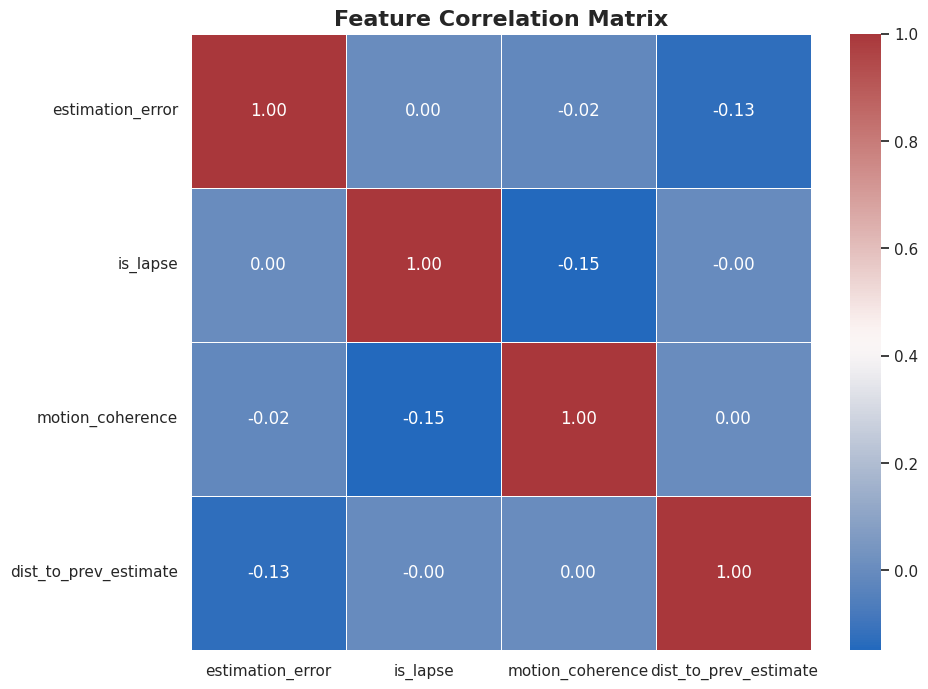

--- Generating Confusion Matrix for Lapse Prediction Model ---


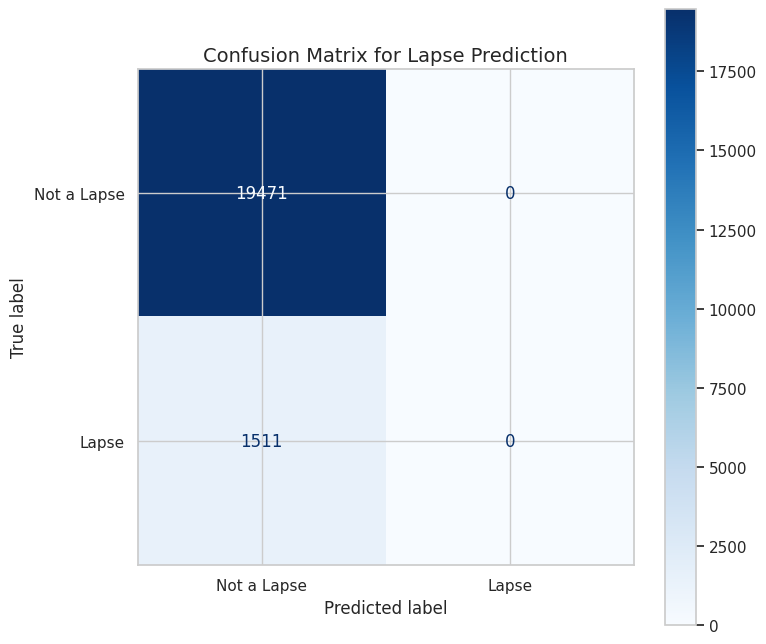

--- Comparing Feature Importance Between Models ---


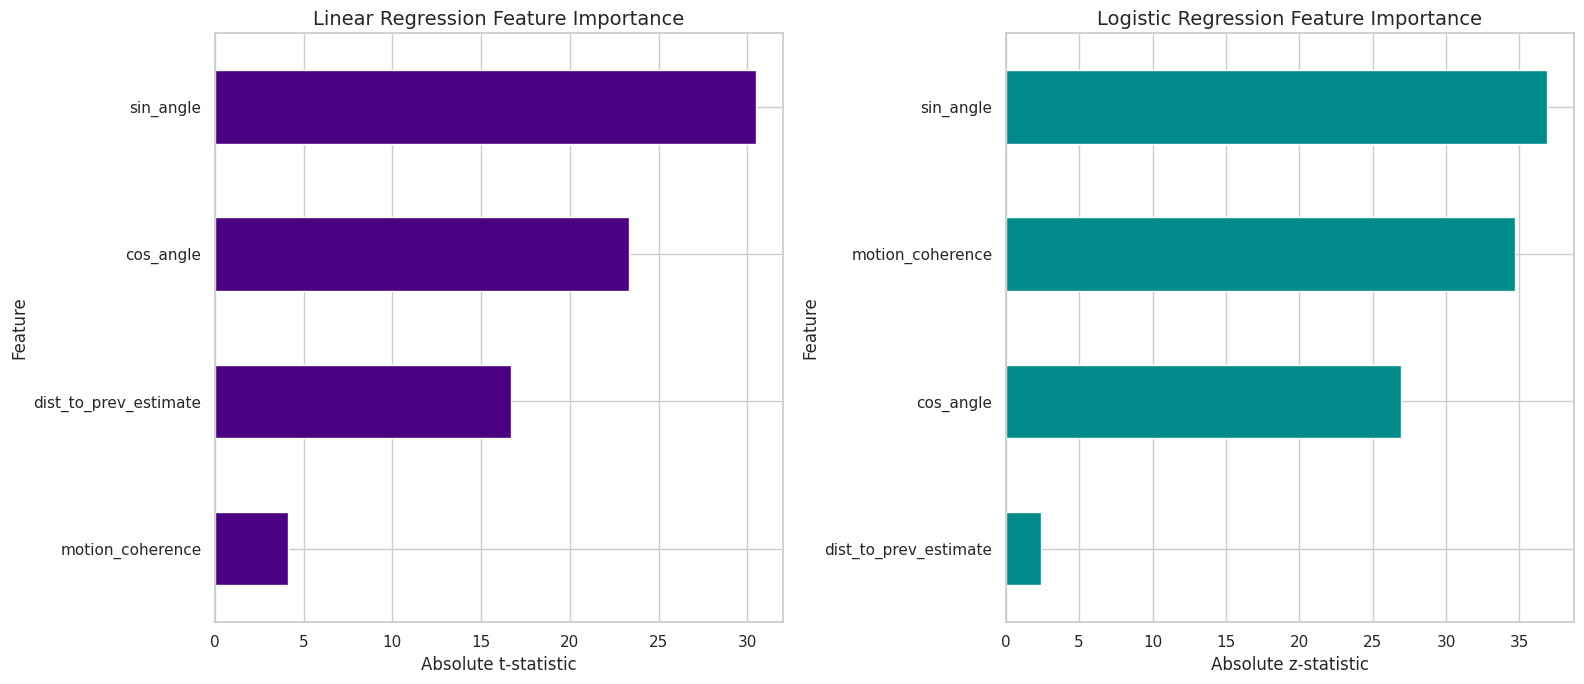

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if 'train_sets' in locals() and 'data01_direction4priors' in train_sets:
    print("--- Generating Correlation Matrix for 'data01_direction4priors' ---")

    df_corr = train_sets['data01_direction4priors'].copy()
    correlation_cols = [
        'estimation_error',
        'is_lapse',
        'motion_coherence',
        'dist_to_prev_estimate'
    ]
    correlation_matrix = df_corr[correlation_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='vlag',
        fmt=".2f",
        linewidths=.5
    )
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.show()

else:
    print("\n Error: The 'train_sets' dictionary was not found.")

if 'train_sets' in locals() and 'test_sets' in locals() and 'data01_direction4priors' in train_sets:
    print("--- Generating Confusion Matrix for Lapse Prediction Model ---")

    train_df = train_sets['data01_direction4priors'].copy()
    test_df = test_sets['data01_direction4priors'].copy()
    LAPSE_THRESHOLD = 90.0
    train_df['is_lapse'] = (np.abs(train_df['estimation_error']) > LAPSE_THRESHOLD).astype(int)
    test_df['is_lapse'] = (np.abs(test_df['estimation_error']) > LAPSE_THRESHOLD).astype(int)
    y_train = train_df['is_lapse']
    X_train = sm.add_constant(pd.DataFrame({
        'motion_coherence': train_df['motion_coherence'],
        'dist_to_prev_estimate': train_df['dist_to_prev_estimate'],
        'sin_angle': np.sin(np.deg2rad(train_df['motion_direction'])),
        'cos_angle': np.cos(np.deg2rad(train_df['motion_direction']))
    }))

    y_test = test_df['is_lapse']
    X_test = sm.add_constant(pd.DataFrame({
        'motion_coherence': test_df['motion_coherence'],
        'dist_to_prev_estimate': test_df['dist_to_prev_estimate'],
        'sin_angle': np.sin(np.deg2rad(test_df['motion_direction'])),
        'cos_angle': np.cos(np.deg2rad(test_df['motion_direction']))
    }))

    logit_model = sm.Logit(y_train, X_train).fit(disp=0)
    y_pred_proba = logit_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not a Lapse', 'Lapse'])
    fig, ax = plt.subplots(figsize=(8, 8))
    display.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix for Lapse Prediction', fontsize=14)
    plt.show()

else:
    print("\n Error: The 'train_sets' or 'test_sets' dictionary was not found.")

if 'train_sets' in locals() and 'data01_direction4priors' in train_sets:
    print("--- Comparing Feature Importance Between Models ---")

    df = train_sets['data01_direction4priors'].copy()
    df['is_lapse'] = (np.abs(df['estimation_error']) > LAPSE_THRESHOLD).astype(int)
    df['sin_angle'] = np.sin(np.deg2rad(df['motion_direction']))
    df['cos_angle'] = np.cos(np.deg2rad(df['motion_direction']))

    predictor_cols = ['motion_coherence', 'dist_to_prev_estimate', 'sin_angle', 'cos_angle']
    linear_df = df[['estimation_error'] + predictor_cols].dropna()
    y_linear = linear_df['estimation_error']
    X_linear = sm.add_constant(linear_df[predictor_cols])
    logit_df = df[['is_lapse'] + predictor_cols].dropna()
    y_logit = logit_df['is_lapse']
    X_logit = sm.add_constant(logit_df[predictor_cols])
    linear_results = sm.OLS(y_linear, X_linear).fit()
    logit_results = sm.Logit(y_logit, X_logit).fit(disp=0)
    importance_df = pd.DataFrame({
        'Feature': X_linear.columns.drop('const'),
        'Linear_Importance (abs t-value)': np.abs(linear_results.tvalues.drop('const')),
        'Logistic_Importance (abs z-value)': np.abs(logit_results.tvalues.drop('const')) # .tvalues gives z-values for Logit
    }).set_index('Feature')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    importance_df['Linear_Importance (abs t-value)'].sort_values().plot(kind='barh', ax=axes[0], color='indigo')
    axes[0].set_title('Linear Regression Feature Importance', fontsize=14)
    axes[0].set_xlabel('Absolute t-statistic')

    importance_df['Logistic_Importance (abs z-value)'].sort_values().plot(kind='barh', ax=axes[1], color='darkcyan')
    axes[1].set_title('Logistic Regression Feature Importance', fontsize=14)
    axes[1].set_xlabel('Absolute z-statistic')

    plt.tight_layout()
    plt.show()

else:
     print("\n Error: The 'train_sets' dictionary was not found.")

#### Feature Correlation Matrix

This heatmap shows the pairwise correlation between the key variables.

* **Weak Correlations:** Most of the predictor variables have very weak linear correlations with each other and with the target variables (`estimation_error` and `is_lapse`). For example, `motion_coherence` has only a -0.15 correlation with `is_lapse`.
* **No Strong Multicollinearity:** The low correlation values between the predictor variables (`motion_coherence` and `dist_to_prev_estimate`) mean that they are not redundant. This confirms that the "multicollinearity" warning in the regression output was not a major issue and that each feature provides independent information.

#### Confusion Matrix for Lapse Prediction

This matrix is a scorecard for the logistic regression model on the test data, showing its predictions versus the actual outcomes.

* **Excellent at Identifying "Not a Lapse":** The model is nearly perfect at identifying trials that are *not* lapses. It correctly classified 19,471 of these trials.
* **Fails to Identify Lapses:** The model's critical weakness is its complete inability to predict a lapse. It predicted "Lapse" 0 times, meaning it incorrectly classified all 1,511 actual lapse trials as "Not a Lapse."
* **Reason for Failure:** This happens because of the **class imbalance** in the data. Lapse trials are rare compared to non-lapse trials. Faced with this imbalance, the model learned that the safest strategy to maximize its overall accuracy is to *always* predict the majority class ("Not a Lapse").

#### Feature Importance Comparison

Those two bar charts compare which features were most influential in two different models. This shows the difference between mechanisms driving the *average error* versus the *probability of a lapse*.

**Linear Regression (Predicting Error Bias):**
* **Most Important:** The `sin_angle` and `cos_angle` are by far the most important features. This means the *direction* of the stimulus has the biggest impact on the *bias* of the error.
* **Also Important:** The distance to the previous estimate (`dist_to_prev_estimate`) is also a strong predictor, confirming the importance of trial history in shaping the error.

**Logistic Regression (Predicting Lapses):**
**Most Important:** The single most important feature is `motion_coherence`. This says that the *clarity* of the stimulus is the primary factor determining whether a participant will have a catastrophic lapse or not.
**Also Important:** The `sin_angle` and `cos_angle` are also significant, but `dist_to_prev_estimate` is the least important.


### For building Bayesian Model


1.  **Two different error mechanisms:**
    * **Fine-tuning Bias:** The precise *bias* of an estimate is heavily influenced by systematic factors related to the stimulus direction and the history of previous trials.
    * **Catastrophic Lapses:** The probability of making a large, guessing-like error is almost entirely driven by the quality of the sensory evidence (the signal strength).

2.  **a Unified Mixture Model:** You have now outgrown simple linear and logistic models. The clear path forward is to build a **Bayesian Mixture Model**. This single, unified model can perfectly capture the two separate mechanisms:

    * It will use **signal strength** to predict the probability of a trial being a **lapse** (from a uniform, guessing distribution).
    * For the trials that are not lapses, it will model the estimation error with a **Von Mises distribution**, using the **stimulus direction** and **previous trial history** to predict the bias (μ) and the **signal strength** to predict the precision (κ).
    * **μ (mu):** The *mean*, or **bias**, of the error distribution. You can model this as a function of the previous trial and the stimulus angle:
        * `μ = f(dist_to_prev_estimate, sin_angle, cos_angle)`
    * **κ (kappa):** The *concentration*, or **precision**, of the error distribution (the inverse of variance). You can model this as a function of signal strength:
        * `κ = f(motion_coherence)`

3.  **Using a Bayesian Modeling Library:** This type of custom probabilistic model is exactly what modern Bayesian libraries are designed for. The most common choices in Python are:
    * **PyMC:** A very popular and intuitive library for probabilistic programming.
    * **Stan:** A powerful and fast statistical modeling language with excellent Python interfaces (`CmdStanPy` or `PyStan`).
